# Generating problem instances
This notebook is used to generate a set of problem instances for the traveling salesman problem with appointment scheduling (TSP-AS) on Friday 5 May 2023.

## Procedure
- Origin is located at (0, 0)
- Customers are located uniformly randomly on a [0, 30]^2 square.
- Travel time between two locations is equal to their Euclidean distance.
- Customer's mean service times $\mu$ are sampled from:.
    - Uniform $U(30, 60)$.
- SCVs of random variables are sampled from a uniform distribution $U(e, l)$.
    - Service time
        - $U(0.1, 0.5)$
        - $U(0.5, 1.5)$
    - Travel time
        - $U(0.1, 0.2)$

## Small example
The code below generates a random instance, saves it as JSON, and loads the JSON as ProblemData instance.

In [23]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from tsp_as.classes import ProblemData, Solution
from tsp_as.plot import plot_instance

In [47]:
def make_random(
    seed,
    dim,
    max_size,
    mean_service_time,
    service_distribution,
    min_size=0,
    min_service_time=0,
    distances_scv_min=0.1,
    distances_scv_max=0.1,
    service_scv_min=1.1,
    service_scv_max=1.5,
    coords=None,
    name=None,
    **kwargs,
):
    """
    Creates a random instance with ``dimension`` locations.

    - Customer locations are randomly sampled from a grid of size `max_size`.
    - Travel times are equal to the Euclidean distance.
    - Service times are either uniform or normally distributed.
    - SCVs are sampled uniformly from a provided interval.
    """
    rng = rnd.default_rng(seed)
    name = "Random instance." if name is None else name
    
    if coords is None:
        coords = rng.integers(1, max_size, size=(dim, 2))
        coords[0, :] = [0, 0]  # depot location

    distances = pairwise_euclidean(coords)
    distances_scv = rng.uniform(
        low=distances_scv_min,
        high=distances_scv_max,
        size=distances.shape,
    )
    np.fill_diagonal(distances_scv, 0)  # no scv travel time on loops

    if service_distribution == 'uniform':
        service = rng.integers(min_service_time, mean_service_time, size=dim) + 1
    elif service_distribution == 'normal':
        service = np.maximum(rng.normal(mean_service_time, mean_service_time/3, size=dim), 1)
    else:
        raise ValueError("Service type distribution unknown.")
        
    if 'service_scv' in kwargs and kwargs['service_scv'] is not None:
        service_scv = kwargs['service_scv']
    else:
        service_scv = rng.uniform(
            low=service_scv_min,
            high=service_scv_max,
            size=service.shape,
        )

        
    service[0] = 0  # depot has no service time
    service_scv[0] = 0

    return ProblemData(
        name,
        coords,
        dim,
        distances,
        distances_scv,
        service,
        service_scv,
        # **kwargs,
    )

def pairwise_euclidean(coords: np.ndarray) -> np.ndarray:
    """
    Computes the pairwise Euclidean distance between the passed-in coordinates.

    Parameters
    ----------
    coords
        An n-by-2 array of location coordinates.

    Returns
    -------
    np.ndarray
        An n-by-n Euclidean distances matrix.

    """
    # Subtract each coordinate from every other coordinate
    diff = coords[:, np.newaxis, :] - coords
    square_diff = diff ** 2
    square_dist = np.sum(square_diff, axis=-1)
    return np.sqrt(square_dist)

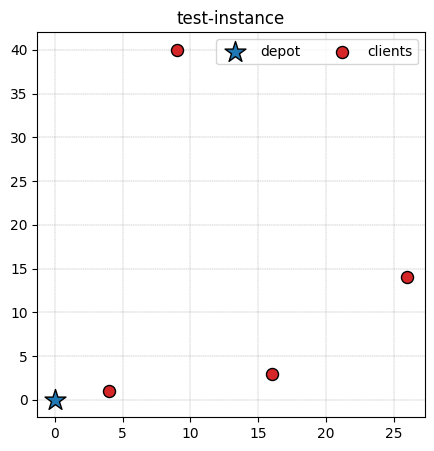

In [48]:
data = make_random(
    seed=0, 
    dim=5, 
    max_size=50, 
    mean_service_time=20,
    service_distribution='uniform',
    distances_scv_min=0.1,
    distances_scv_max=0.5,
    service_scv_min=1.1,
    service_scv_max=1.5,
    name="test-instance"
)
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
plot_instance(ax, data)

In [49]:
data_dict = {
    'coords': data.coords,
    'dimension': data.dimension,
    'distances': data.distances,
    'distances_scv': data.distances_scv,
    'service_scv': data.service_scv,
    'service': data.service,
}

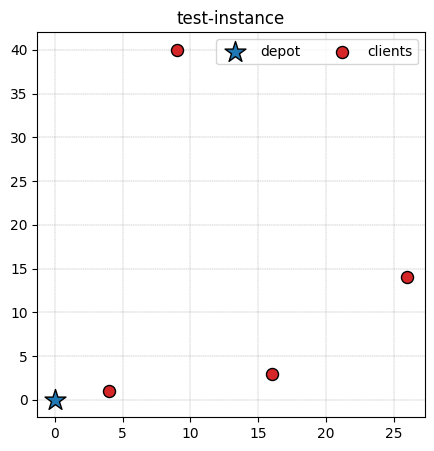

In [50]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return np.round(obj, 3).tolist()
        return json.JSONEncoder.default(self, obj)

def data2dict(data):
    return {
        'coords': data.coords,
        'dimension': data.dimension,
        'distances': data.distances,
        'distances_scv': data.distances_scv,
        'service_scv': data.service_scv,
        'service': data.service,
    }

def save_data(data, out_dir):
    path_dir = Path(out_dir)
    path_dir.mkdir(exist_ok=True, parents=True)
    path_file = path_dir / (data.name + '.json')
 
    with open(path_file, 'w', encoding='utf-8') as fh:
        json.dump(data2dict(data), fh, ensure_ascii=False, indent=4, cls=NumpyEncoder)

# Check that the data is correctly saved and loaded
save_data(data, 'tmp/')
data = ProblemData.from_file('tmp/test-instance.json')    
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
plot_instance(ax, data)

## Generate instances

In [51]:
OUT_DIR = '../experiments/230505-benchmark-instances/instances/'

In [52]:
design = {
    'instance_idx': list(range(5)),
    'n_customers': [5, 10, 15, 20, 25, 30],
    'service_distribution': ['uniform'],
    'service_scv': [(0.1, 0.5), (0.5, 1.5)],
    'distances_scv': [(0.1, 0.2)],
}

In [53]:
for n_customers in design['n_customers']:
    instance_seed = 0 # Seed counter per instance size to randomize locations
    
    for instance_idx in design['instance_idx']:
        for sd_idx, service_distribution in enumerate(design['service_distribution']):
            for d_idx, distances_scv in enumerate(design['distances_scv']):
                for s_idx, service_scv in enumerate(design['service_scv']):
                    instance_seed += 1 
                    name = f"n{n_customers}-idx{instance_idx}-distribution{sd_idx}-travel{d_idx}-serv{s_idx}"
                    
                    data = make_random(
                        seed=instance_seed, 
                        dim=n_customers+1, 
                        max_size=30, 
                        mean_service_time=60,
                        min_service_time=30,
                        service_distribution=service_distribution,
                        distances_scv_min=distances_scv[0],
                        distances_scv_max=distances_scv[1],
                        service_scv_min=service_scv[0],
                        service_scv_max=service_scv[1],
                        name=name
                    )

                    save_data(data, OUT_DIR)